In [144]:
from pathlib import Path
import torch
import numpy as np
import pandas as pd

import sys
sys.path.append("../")
from nnperm.spec import PermutationSpec

In [145]:
# "VGG-16": "lottery_8146fc7e9839615729ee764a8019bdc5",
# "ResNet-20": "lottery_0683974d98b4b6cb906aa0b80db9e2f5",
models = {
    "688106d9fc0da7db4cebd981434750ee": ("cifar_vgg_16_8", "VGG-16", 1),
    "812938fad9d6a452c60de777ad8b9ba2": ("cifar_vgg_16_16", "VGG-16", 2),
    "e1ee2ce029f3688fdba8d16bcd72101b": ("cifar_vgg_16_32", "VGG-16", 3),
    "b49ffe5e5a5c5bc82fd39df5f148ee0d": ("cifar_vgg_16_64", "VGG-16", 4),
    "3ed390b5f8f0b92d658244d053e538e7": ("cifar_vgg_16_128", "VGG-16", 5),
    "23d95a4841f5114daaeb195dcd3bce62": ("cifar_vgg_16_256", "VGG-16", 6),
    "57c37a2b8fd5a5c74cb0f565fd63e73c": ("cifar_resnet_20_16", "ResNet-20", 2),
    "9cdece881a2eff8a65aeecba308aabe6": ("cifar_resnet_20_32", "ResNet-20", 3),
    "889c23b4d2b571fabafee827cc8697cd": ("cifar_resnet_20_64", "ResNet-20", 4),
    "7ce57051a6cf02ec112ad4d37ffccf93": ("cifar_resnet_20_128", "ResNet-20", 5),
    "42bf0fd10b6e5a3a3e35e74f86c0fc90": ("cifar_resnet_20_256", "ResNet-20", 6),
    "2fec827265eaaaa263b155b4ef1f43a7": ("cifar_resnet_20_512", "ResNet-20", 7),
}
algorithms = {
    "weight_linear": "weight matching",
    "activation_cifar10_50000": "activation matching",
}

width_stats = torch.load("../refactor-outputs/width-stats/model_info.pt")

def fp_rows(fixed_points_dict, other_values, layers):
    rows = []
    all_nonzero, all_total = 0, 0
    for i, k in enumerate(layers):
        nonzero = np.count_nonzero(fixed_points_dict[k])
        total = len(fixed_points_dict[k])
        rows.append({
            "layer": k,
            "layer.number": i,
            "fixed_points": nonzero,
            "total": total,
            "fraction": nonzero / total,
            **other_values
        })
        all_nonzero += nonzero
        all_total += total
    rows.append({
        "layer": "all",
        "fixed_points": all_nonzero,
        "total": all_total,
        "fraction": all_nonzero / all_total,
        **other_values
    })
    return rows

def barrier_rows(barriers_dict):
    return {
        **{k: max(v) if "loss" in k else -min(v) if "acc" in k else len(v) for k, v in barriers_dict.items()},
        **{k+".idx": np.argmax(v) if "loss" in k else np.argmin(v) if "acc" in k else len(v) for k, v in barriers_dict.items()},
    }

def make_df():
    barrier_df = []
    fixed_points_df = []
    for file in Path("../refactor-outputs/transitivity/width/").rglob("*.pt"):
        stats = torch.load(file)
        hash = str(file).split("lottery_")[1].split("-")[0]
        align_type = str(file).split("width/")[1].split("/")[0]
        align_name = algorithms[align_type]
        model, name, width_idx = models[hash]
        # ps_file = next(iter(Path(f"../refactor-outputs/layer-align-more-bias/{model}/replicate_1-2").glob("perm-*.pt")))
        # _, perm_spec = PermutationSpec.load_from_file(ps_file)
        # layers = list(perm_spec.group_to_axes.keys())
        layers = list(width_stats[model]["group_to_axes"].keys())

        for item in stats["stats"]:
            path_info = {
                "Model": name,
                "Method": align_name,
                "width": int(model.split("_")[-1]),
                "Width": width_idx,
                "path": item['path'],
                "Permutations": len(item['path']),
            }
            barrier_df.append({**path_info, "cycle": False, "train": True, **barrier_rows(item["path_train"])})
            barrier_df.append({**path_info, "cycle": False, "train": False, **barrier_rows(item["path_test"])})
            barrier_df.append({**path_info, "cycle": True, "train": True, **barrier_rows(item["cycle_train"])})
            barrier_df.append({**path_info, "cycle": True, "train": False, **barrier_rows(item["cycle_test"])})
            fixed_points_df += fp_rows(item["fixed_points"], {**path_info, "cycle": True}, layers)
    barrier_df = pd.DataFrame(barrier_df)
    fixed_points_df = pd.DataFrame(fixed_points_df)
    return barrier_df, fixed_points_df

barrier_df, fixed_points_df = make_df()

In [146]:
# filter out only 2 and 3 length
barrier_df = barrier_df[barrier_df["Permutations"] < 4]
fixed_points_df = fixed_points_df[fixed_points_df["Permutations"] < 4]

# change permutations to something more descriptive
perm_name_change = {
    2: "A, $P_{B \\rightarrow A}[B]$",
    3: "$P_{A \\rightarrow C}[A], P_{B \\rightarrow C}[B]$",
    4: "$A \\rightarrow C \\rightarrow D \\rightarrow B$",
    5: "$A \\rightarrow C \\rightarrow D \\rightarrow E \\rightarrow B$",
}
barrier_df["Permutations"] = barrier_df["Permutations"].apply(lambda x: perm_name_change[x])

perm_name_change = {
    2: "identity",
    3: "$P_{B \\rightarrow C \\rightarrow A}$ and $P_{B \\rightarrow A}$",
    4: "$A \\rightarrow C \\rightarrow D \\rightarrow B and $A \\rightarrow B$",
    5: "$A \\rightarrow C \\rightarrow D \\rightarrow E \\rightarrow B and $A \\rightarrow B$",
}
fixed_points_df["Permutations"] = fixed_points_df["Permutations"].apply(lambda x: perm_name_change[x])

In [147]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_barrier(data, title, barrier_type, palette="tab10"):
    print(title)
    ax = sns.lineplot(data=data, x="Width", y=barrier_type, hue="Permutations", style="Method", palette=palette)
    if barrier_type == "acc_barrier":
        ax.axhline(0.02, 0, 10, linestyle="dotted", color="black", label="LMC threshold")
    # if barrier_type == "acc_barrier" or "fixed_points" in title:
    #     ax.set_ylim(0, 1)
    # else:
    #     if "ResNet" in title:
    #         ax.set_ylim(0, 5.5)
    #     else:
    #         ax.set_ylim(0, 2.6)

    ticks = sorted([int(x) for x in data["Width"].unique()])
    ticklabels = sorted([int(x) for x in data["width"].unique()])
    ax.set(xticks=ticks, xticklabels=ticklabels)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles[1:3] + handles[4:7], labels=labels[1:3] + labels[4:7])

    ax.set_xlabel("Width")
    if "fixed_points" in title:
        ax.set_ylabel("Fixed points (fraction)")
    else:
        ax.set_ylabel(f"{'Train' if 'train' in title else 'Test'} {'error' if barrier_type == 'acc_barrier' else 'loss'} barrier")

    plt.savefig(f"../figures/transitivity-width-{title}.pdf")
    plt.show()

def plot_train_test(data, title):
    for barrier_type in ["acc_barrier", "loss_barrier"]:
        plot_barrier(data[data["train"]], f"{title}_train_{barrier_type}", barrier_type)
        plot_barrier(data[~data["train"]], f"{title}_test_{barrier_type}", barrier_type)

def plot(barrier_df, fixed_points_df):
    for model in barrier_df["Model"].unique():
        barrier_subset = barrier_df[barrier_df["Model"] == model]
        barrier_subset.sort_values("Permutations", ascending=False)
        fp_subset = fixed_points_df[(fixed_points_df["Model"] == model) & (fixed_points_df["cycle"]) & (fixed_points_df["layer"] == "all")]
        fp_subset.sort_values("Permutations", ascending=False)
        plot_train_test(barrier_subset[~barrier_subset["cycle"]], model)
        plot_barrier(fp_subset, f"{model}_fixed_points", "fraction", [sns.color_palette("tab10")[7], sns.color_palette("tab10")[2]])
        # plot_train_test(barrier_subset[barrier_subset["cycle"]], model + " cycle")

VGG-16_train_acc_barrier


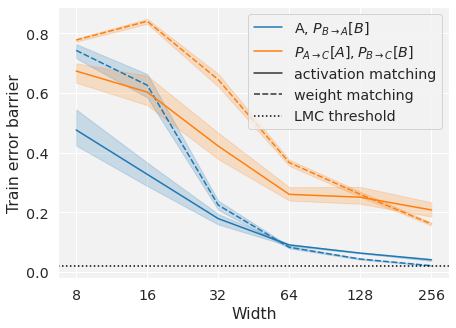

VGG-16_test_acc_barrier


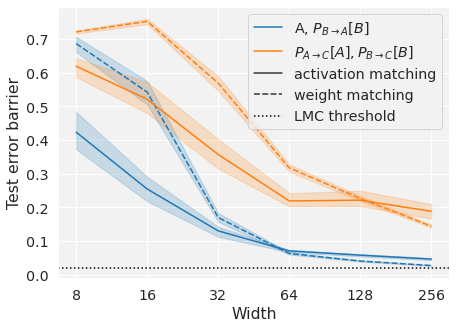

VGG-16_train_loss_barrier


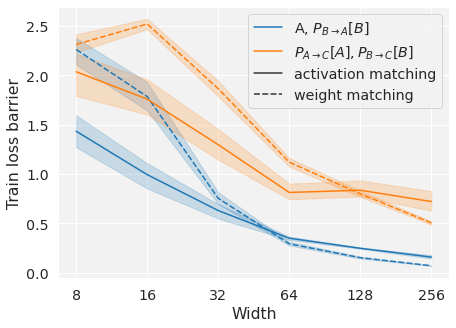

VGG-16_test_loss_barrier


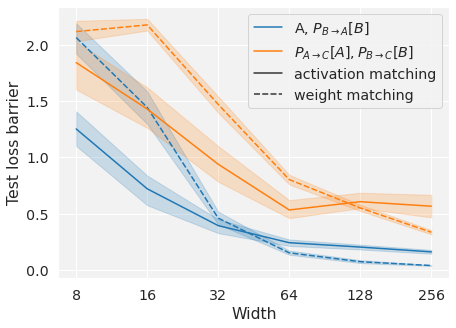

VGG-16_fixed_points


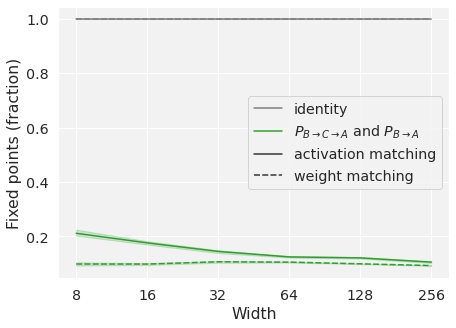

ResNet-20_train_acc_barrier


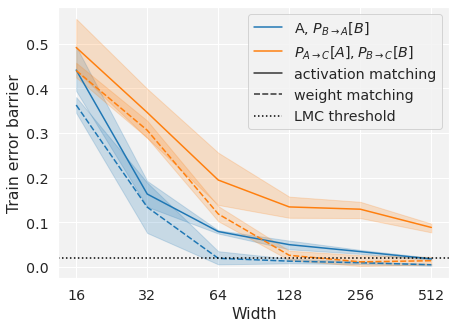

ResNet-20_test_acc_barrier


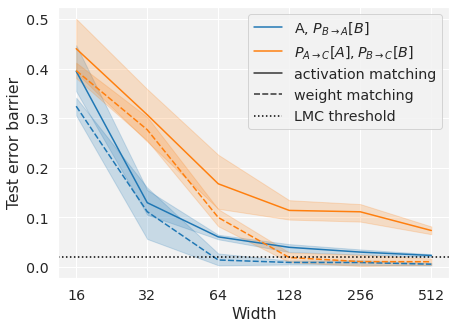

ResNet-20_train_loss_barrier


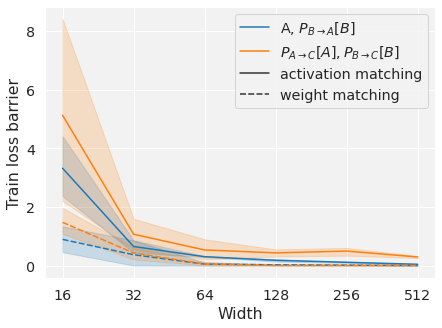

ResNet-20_test_loss_barrier


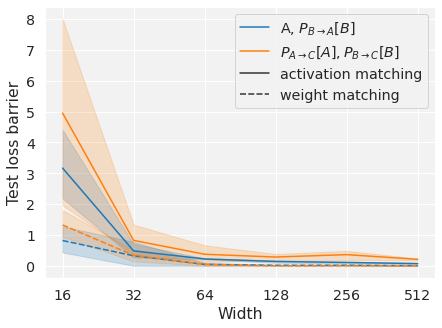

ResNet-20_fixed_points


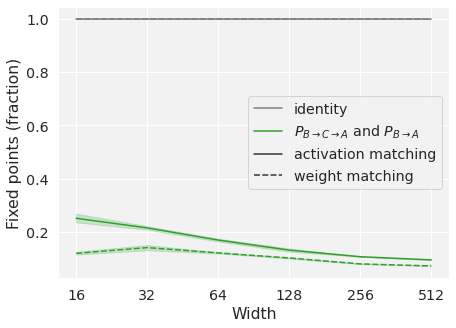

In [148]:
sns.set(rc={'figure.figsize':(7, 5)})
sns.set(font_scale=1.3)
sns.set_style("darkgrid", {"axes.facecolor": ".95"})

plot(barrier_df, fixed_points_df)